# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

## 1. 🔧 Configuración Inicial

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


## 2. 📦 Extracción de Datos

In [4]:
# SQL query to extract data on ICU patients with Intracerebral Hemorrhage (ICH)
query = """
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d
    ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
  WHERE LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
),

chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
    AVG(CASE WHEN itemid = 223762 AND valuenum BETWEEN 33 AND 43 THEN valuenum END) AS temperature_avg
  FROM `ogi-uci-i61.mimiciv_icu.chartevents` c
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` i ON c.stay_id = i.stay_id
  WHERE c.itemid IN (220045, 220052, 220210, 220277, 223762)
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
),

cbc_labs AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(wbc) AS wbc_avg,
    MIN(hemoglobin) AS hgb_min
  FROM `ogi-uci-i61.mimiciv_derived.complete_blood_count`
  GROUP BY subject_id, hadm_id
),

chem_labs AS (
  SELECT
    subject_id,
    hadm_id,
    MAX(creatinine) AS creatinine_max,
    AVG(glucose) AS glucose_avg
  FROM `ogi-uci-i61.mimiciv_derived.chemistry`
  GROUP BY subject_id, hadm_id
),

coag_labs AS (
  SELECT
    subject_id,
    hadm_id,
    MAX(inr) AS inr_max,
    MAX(pt) AS pt_max
  FROM `ogi-uci-i61.mimiciv_derived.coagulation`
  GROUP BY subject_id, hadm_id
)

SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  a.intime,
  a.outtime,
  a.first_careunit,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,
  TIMESTAMP_DIFF(adm.dischtime, adm.admittime, HOUR) AS hosp_los_hours,
  adm.discharge_location,
  adm.hospital_expire_flag,

  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN i.icd_code END, '; ') AS ich_icd_codes,
  STRING_AGG(CASE
               WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN CONCAT(i.icd_code, ': ', d.long_title)
               ELSE i.icd_code
             END, '; ') AS all_diagnoses,

  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.temperature,
  vitals.spo2,
  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,
  ce.temperature_avg,

  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg,
  cbc.hgb_min,
  chem.creatinine_max,
  chem.glucose_avg,
  coag.inr_max,
  coag.pt_max,

  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,
  CASE WHEN addmeds.subject_id IS NOT NULL THEN 1 ELSE 0 END AS on_statins_or_antiplatelets,

  readmit.readmitted_stay

FROM `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN `ogi-uci-i61.mimiciv_hosp.patients` p ON a.subject_id = p.subject_id
JOIN `ogi-uci-i61.mimiciv_hosp.admissions` adm ON a.hadm_id = adm.hadm_id
JOIN ich_admissions ich ON a.hadm_id = ich.hadm_id

LEFT JOIN `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i ON a.hadm_id = i.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

LEFT JOIN (
  SELECT
    stay_id,
    gcs_verbal,
    gcs_motor,
    gcs_eyes,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.gcs`
) s ON a.stay_id = s.stay_id AND s.rn = 1

LEFT JOIN (
  SELECT
    stay_id,
    heart_rate,
    mbp,
    resp_rate,
    temperature,
    spo2,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.vitalsign`
) vitals ON a.stay_id = vitals.stay_id AND vitals.rn = 1

LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id

LEFT JOIN (
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id AND a2.intime > a1.outtime
  GROUP BY a1.subject_id, a1.stay_id
) readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

LEFT JOIN `ogi-uci-i61.mimiciv_derived.charlson` charlson ON a.hadm_id = charlson.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.apsiii` apsi ON a.stay_id = apsi.stay_id
LEFT JOIN cbc_labs cbc ON a.subject_id = cbc.subject_id AND a.hadm_id = cbc.hadm_id
LEFT JOIN chem_labs chem ON a.subject_id = chem.subject_id AND a.hadm_id = chem.hadm_id
LEFT JOIN coag_labs coag ON a.subject_id = coag.subject_id AND a.hadm_id = coag.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(aspirin|clopidogrel|atorvastatin|rosuvastatin)')
    AND drug_type = 'MAIN'
) addmeds ON a.subject_id = addmeds.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.procedures_icd`
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

GROUP BY
  a.subject_id, a.hadm_id, a.stay_id, a.intime, a.outtime, a.first_careunit,
  p.gender, p.anchor_age,
  adm.admittime, adm.dischtime, adm.discharge_location, adm.hospital_expire_flag,
  s.gcs_verbal, s.gcs_motor, s.gcs_eyes,
  vitals.heart_rate, vitals.mbp, vitals.resp_rate, vitals.temperature, vitals.spo2,
  ce.heart_rate_avg, ce.mbp_avg, ce.resp_rate_avg, ce.spo2_avg, ce.temperature_avg,
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg, cbc.hgb_min,
  chem.creatinine_max, chem.glucose_avg,
  coag.inr_max, coag.pt_max,
  hyper.hadm_id, hydro.hadm_id, cad.hadm_id,
  anticoag.subject_id, addmeds.subject_id, neuroproc.hadm_id,
  readmit.readmitted_stay
"""

# Execute the query and convert the result to a DataFrame
df = client.query(query).to_dataframe()
df


,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,glucose_avg,inr_max,pt_max,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,readmitted_stay
0,14456616,23353249,36024787,M,50,2153-11-28 02:43:00,2153-11-29 18:50:27,Medical/Surgical Intensive Care Unit (MICU/SICU),40,361,...,168.062500,1.4,15.3,1,0,0,1,0,1,31533821
1,11962176,26112203,38577294,F,69,2206-01-19 18:25:45,2206-01-20 12:52:31,Medical Intensive Care Unit (MICU),18,145,...,100.000000,0.9,10.2,0,0,1,1,1,1,31509398
2,18023972,25060907,35520106,M,76,2137-05-24 22:56:04,2137-05-26 17:13:31,Neuro Intermediate,43,67,...,92.000000,1.3,13.7,1,0,0,0,0,0,<NA>
3,15123048,28055831,36602002,M,73,2147-11-28 03:33:00,2147-11-29 17:42:31,Trauma SICU (TSICU),38,10,...,70.000000,1.5,16.4,1,0,0,0,1,0,<NA>
4,17374907,20787911,30591063,F,82,2185-05-29 15:53:34,2185-06-05 15:09:42,Neuro Surgical Intensive Care Unit (Neuro SICU),168,240,...,257.450000,1.7,18.8,0,0,1,1,1,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,15995107,24435626,35027940,M,70,2153-12-17 20:25:00,2153-12-24 15:33:52,Neuro Intermediate,163,213,...,276.666667,1.3,13.7,0,0,0,1,0,1,32227870
3714,12781657,20064443,37279829,F,80,2143-11-25 02:40:22,2143-11-26 17:09:58,Medical/Surgical Intensive Care Unit (MICU/SICU),39,68,...,93.250000,1.2,12.9,0,0,0,1,0,0,<NA>
3715,19923870,21666788,34355751,F,89,2168-11-08 22:12:00,2168-11-10 22:16:11,Neuro Intermediate,48,212,...,93.000000,1.1,11.9,1,0,0,1,0,0,<NA>
3716,13365499,22663844,34325152,F,82,2137-05-12 09:40:00,2137-05-13 17:20:44,Cardiac Vascular Intensive Care Unit (CVICU),32,7,...,NaN,NaN,NaN,1,0,0,0,0,0,<NA>


In [5]:

print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'age', 'intime',
       'outtime', 'first_careunit', 'icu_los_hours', 'hosp_los_hours',
       'discharge_location', 'hospital_expire_flag', 'ich_icd_codes',
       'all_diagnoses', 'gcs_verbal', 'gcs_motor', 'gcs_eyes', 'heart_rate',
       'mbp', 'resp_rate', 'temperature', 'spo2', 'heart_rate_avg', 'mbp_avg',
       'resp_rate_avg', 'spo2_avg', 'temperature_avg',
       'charlson_comorbidity_index', 'apsiii', 'wbc_avg', 'hgb_min',
       'creatinine_max', 'glucose_avg', 'inr_max', 'pt_max',
       'has_hypertension', 'has_hydrocephalus', 'has_cad',
       'has_anticoagulation', 'had_neurosurgery',
       'on_statins_or_antiplatelets', 'readmitted_stay'],
      dtype='object')


In [6]:
import pandas as pd

# Remove patients who died in the hospital
df = df[df['hospital_expire_flag'] == 0]
print(f"Remaining patients after removing in-hospital deaths: {len(df)}")

# Create target variable (readmitted)
print("\nNulls in readmitted_stay before fillna:", df['readmitted_stay'].isnull().sum())

# Check how many unique stay IDs there are
unique_stay_ids = df['stay_id'].nunique()
print(f"\nNumber of unique stay IDs: {unique_stay_ids}")

# Check for duplicate stay IDs (number of non-unique entries)
duplicate_stay_ids = df.duplicated(subset='stay_id', keep=False).sum()
print(f"Number of duplicate stay ID rows: {duplicate_stay_ids}")

# Display example duplicate stay IDs and how many times they appear
duplicated_stay_counts = df['stay_id'].value_counts()
duplicated_stay_ids = duplicated_stay_counts[duplicated_stay_counts > 1]
print(f"\nExample of duplicated stay IDs and their counts:\n{duplicated_stay_ids.head()}")

# Check how many unique hadm IDs there are
unique_hadm_ids = df['hadm_id'].nunique()
print(f"\nNumber of unique hadm IDs: {unique_hadm_ids}")

# Check for duplicate hadm IDs (number of non-unique entries)
duplicate_hadm_ids = df.duplicated(subset='hadm_id', keep=False).sum()
print(f"Number of duplicate hadm ID rows: {duplicate_hadm_ids}")

# Check which columns vary across duplicate stay_id rows
if not duplicated_stay_ids.empty:
    example_stay_id = duplicated_stay_ids.index[0]
    dup_rows = df[df['stay_id'] == example_stay_id]
    print(f"\nInspecting differences for stay_id = {example_stay_id}")
    differing_columns = dup_rows.nunique().loc[lambda x: x > 1].index.tolist()
    print(f"Columns with differing values across duplicates: {differing_columns}")
else:
    print("\nNo duplicated stay IDs found.")

# Define readmitted (1 if readmitted_stay is not null, 0 otherwise)
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)
print("Class distribution in readmitted:", df['readmitted'].value_counts())

# Convert numeric/categorical columns
df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'])
df['gcs_verbal'] = df['gcs_verbal'].astype('category')
df['gcs_motor'] = df['gcs_motor'].astype('category')
df['gcs_eyes'] = df['gcs_eyes'].astype('category')
df['gender'] = df['gender'].astype('category')

# Split semicolon-separated ICD entries
df['all_diagnoses_list'] = df['all_diagnoses'].str.split(';')

# Extract and count all ICD codes excluding ICH
all_codes = df['all_diagnoses_list'].explode().str.strip()
all_codes = all_codes.str.split(':').str[0].str.strip()
all_codes = all_codes[all_codes != '']

# Get ICH codes from the ICH field
ich_codes = df['ich_icd_codes'].str.split(';').explode().str.strip().unique()
ich_codes = [code for code in ich_codes if code]
non_ich_codes = all_codes[~all_codes.isin(ich_codes)]

# Frequency count of non-ICH codes
non_ich_code_counts = non_ich_codes.value_counts()
top_10_non_ich_codes = non_ich_code_counts.head(20).index.tolist()
print(f"\nTop 10 most frequent non-ICH ICD-10 codes: {top_10_non_ich_codes}")
print("Frequency of non-ICH codes:")
print(non_ich_code_counts.head(20))

# One-hot encode top 10 non-ICH codes
for code in top_10_non_ich_codes:
    df[f'non_ich_{code}'] = df['all_diagnoses'].str.contains(code, na=False).astype(int)

df = df.drop(columns=['all_diagnoses_list'], errors='ignore')

# One-hot encode top 7 ICH codes
df['ich_icd_codes_list'] = df['ich_icd_codes'].str.split(';')
all_ich_codes = df['ich_icd_codes_list'].explode().str.strip()
all_ich_codes = all_ich_codes[all_ich_codes != '']
ich_code_counts = all_ich_codes.value_counts()
top_7_ich_codes = ich_code_counts.head(7).index.tolist()
print(f"\nTop 7 most frequent ICH ICD-10 codes: {top_7_ich_codes}")
print("Frequency of ICH codes:")
print(ich_code_counts)

for code in top_7_ich_codes:
    df[f'ich_{code}'] = df['ich_icd_codes'].str.contains(code, na=False).astype(int)

df = df.drop(columns=['ich_icd_codes_list'], errors='ignore')

df


Remaining patients after removing in-hospital deaths: 2857

Nulls in readmitted_stay before fillna: 2077

Number of unique stay IDs: 2857
Number of duplicate stay ID rows: 0

Example of duplicated stay IDs and their counts:
Series([], Name: count, dtype: Int64)

Number of unique hadm IDs: 2538
Number of duplicate hadm ID rows: 593

No duplicated stay IDs found.
Class distribution in readmitted: readmitted
0    2077
1     780
Name: count, dtype: int64

Top 10 most frequent non-ICH ICD-10 codes: ['I10', 'E785', 'G936', '4019', 'R29810', 'Z87891', '3485', 'R4701', 'N390', 'R1310', 'Z781', 'G8194', 'R471', '2724', 'Z20822', 'Z66', 'Z7901', 'G8191', 'I2510', 'N179']
Frequency of non-ICH codes:
all_diagnoses_list
I10       1022
E785       806
G936       732
4019       670
R29810     567
Z87891     431
3485       415
R4701      410
N390       395
R1310      388
Z781       371
G8194      370
R471       346
2724       330
Z20822     329
Z66        320
Z7901      305
G8191      290
I2510      28

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,non_ich_G8191,non_ich_I2510,non_ich_N179,ich_431,ich_I618,ich_I611,ich_I615,ich_I619,ich_I610,ich_I614
0,14456616,23353249,36024787,M,50,2153-11-28 02:43:00,2153-11-29 18:50:27,Medical/Surgical Intensive Care Unit (MICU/SICU),40,361,...,0,0,1,0,1,0,0,0,0,0
1,11962176,26112203,38577294,F,69,2206-01-19 18:25:45,2206-01-20 12:52:31,Medical Intensive Care Unit (MICU),18,145,...,0,1,1,0,0,0,0,0,0,0
2,18023972,25060907,35520106,M,76,2137-05-24 22:56:04,2137-05-26 17:13:31,Neuro Intermediate,43,67,...,0,0,0,0,0,0,0,0,0,1
4,17374907,20787911,30591063,F,82,2185-05-29 15:53:34,2185-06-05 15:09:42,Neuro Surgical Intensive Care Unit (Neuro SICU),168,240,...,0,1,1,0,0,1,0,0,0,0
6,18021461,23338824,38042052,M,69,2169-06-28 05:56:00,2169-06-29 14:35:16,Neuro Intermediate,33,33,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,17416494,27859317,34531454,F,61,2133-09-18 02:28:00,2133-10-26 17:09:44,Surgical Intensive Care Unit (SICU),927,928,...,0,0,0,1,0,0,0,0,0,0
3711,10336878,23674027,37699009,F,70,2175-06-27 21:57:00,2175-06-28 14:32:04,Neuro Surgical Intensive Care Unit (Neuro SICU),17,282,...,0,1,0,0,0,0,1,0,0,0
3713,15995107,24435626,35027940,M,70,2153-12-17 20:25:00,2153-12-24 15:33:52,Neuro Intermediate,163,213,...,0,0,0,0,0,0,0,1,0,0
3715,19923870,21666788,34355751,F,89,2168-11-08 22:12:00,2168-11-10 22:16:11,Neuro Intermediate,48,212,...,0,0,0,0,0,1,0,0,0,0


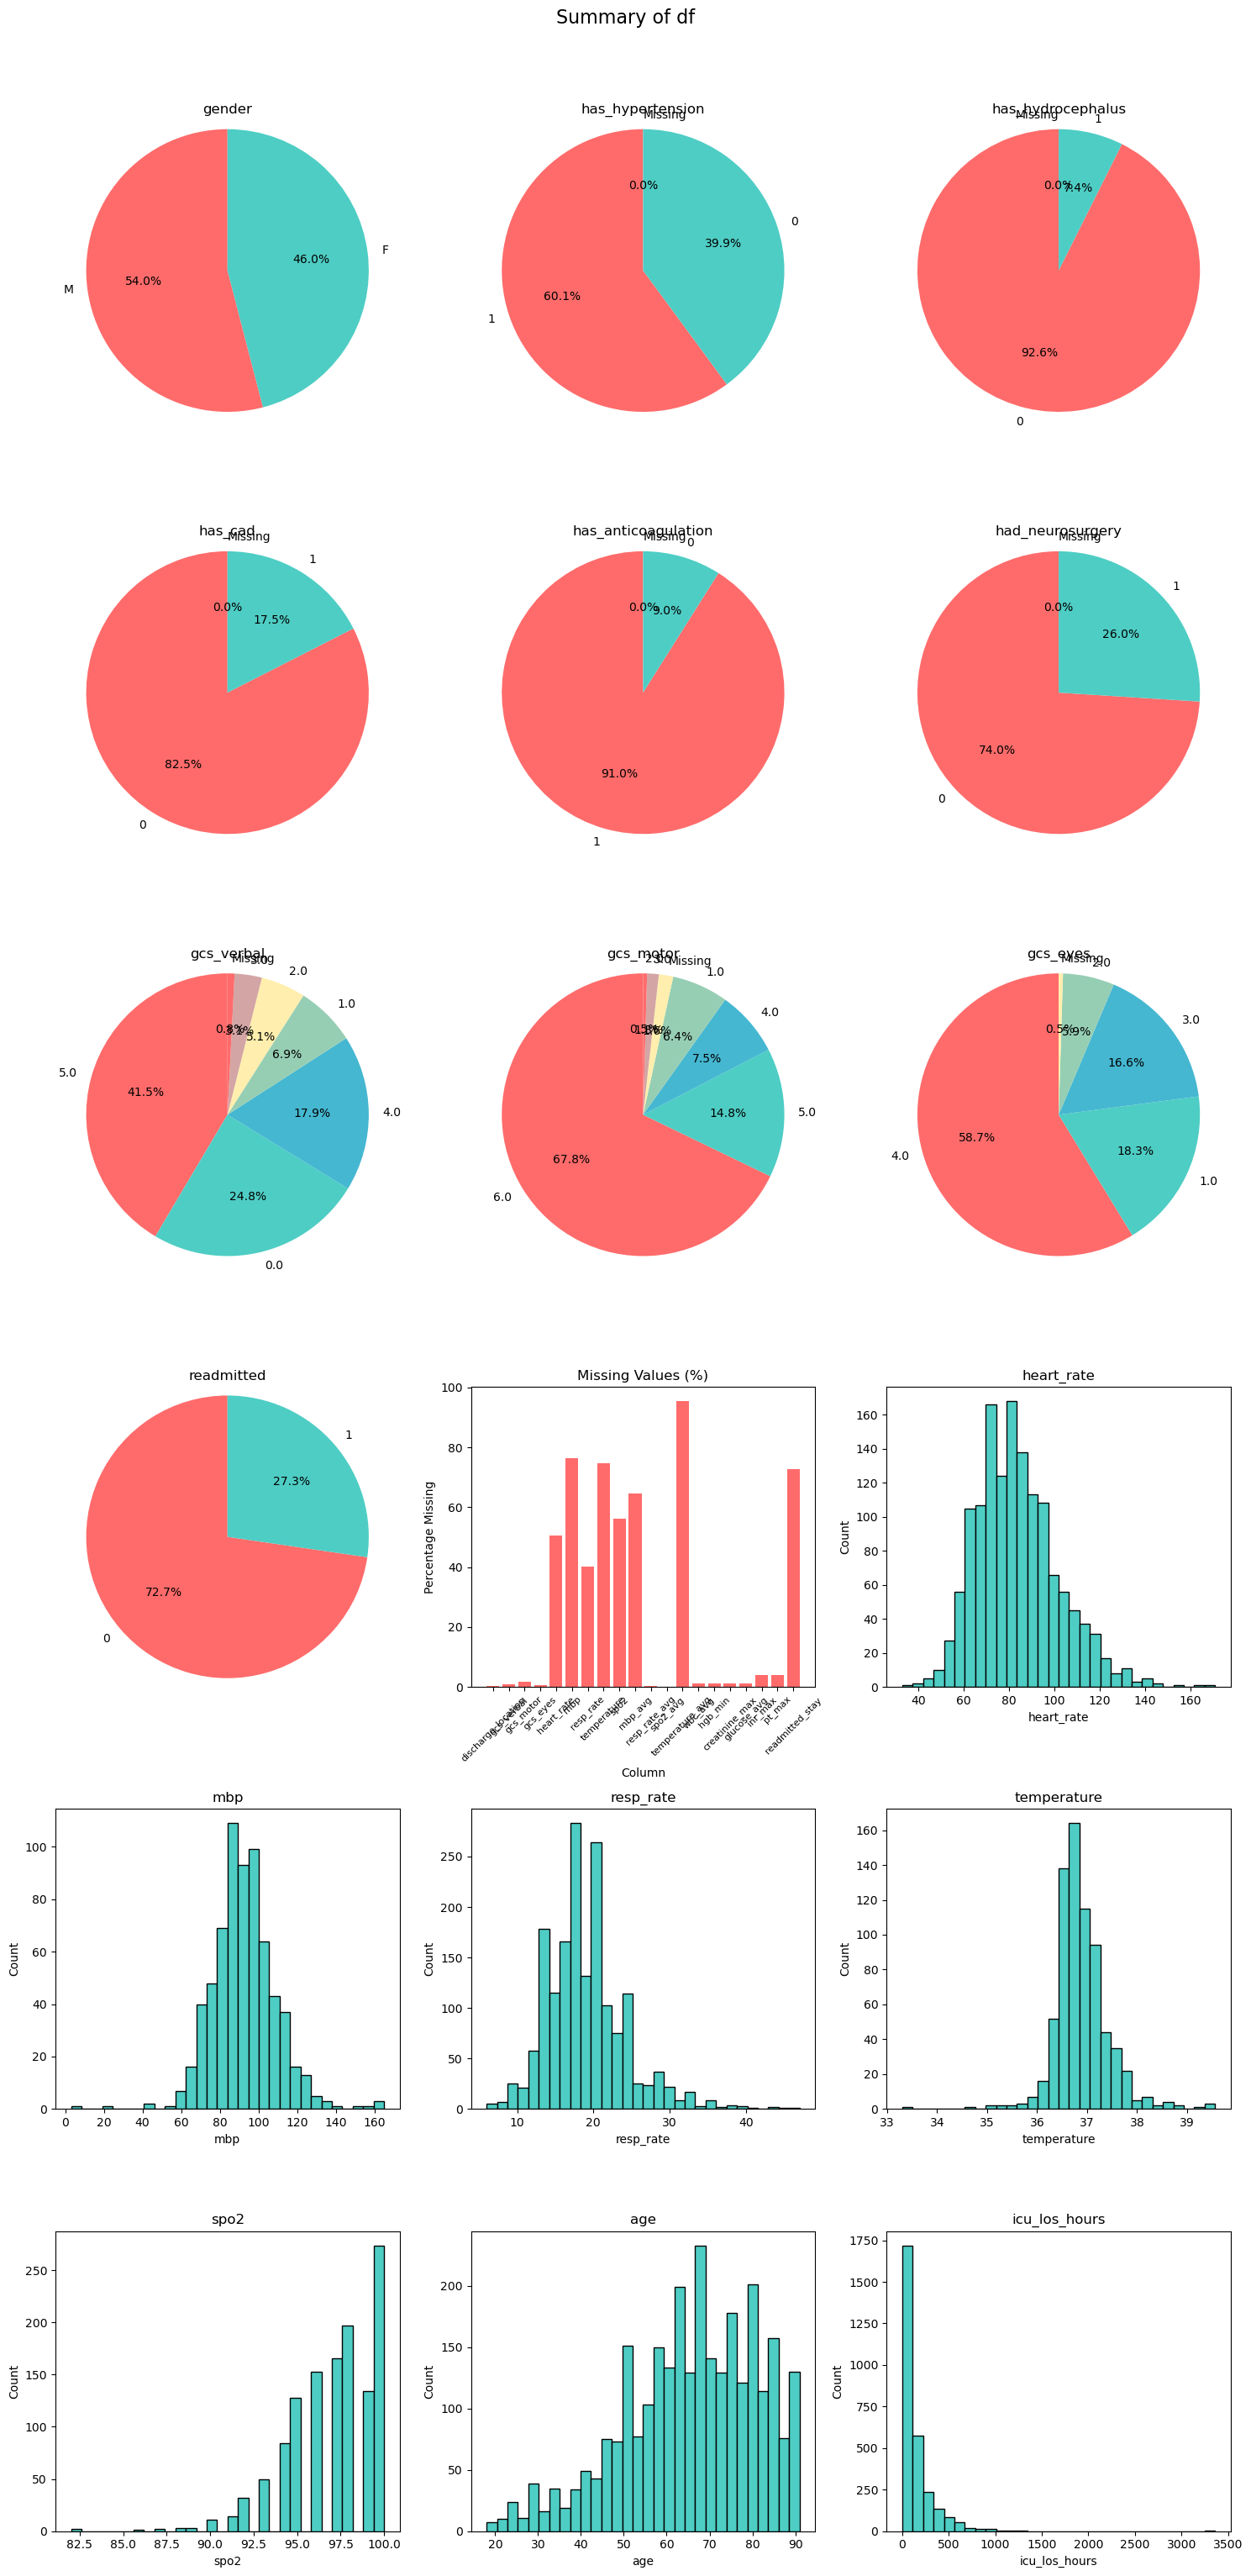

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,ich_431,ich_I618,ich_I615,ich_I611,ich_I619,ich_I610,ich_I614,non_ich_G8191,non_ich_I2510,non_ich_N179
0,14456616,23353249,36024787,M,50,2153-11-28 02:43:00,2153-11-29 18:50:27,Medical/Surgical Intensive Care Unit (MICU/SICU),40,361,...,0,1,0,0,0,0,0,0,0,1
1,11962176,26112203,38577294,F,69,2206-01-19 18:25:45,2206-01-20 12:52:31,Medical Intensive Care Unit (MICU),18,145,...,0,0,0,0,0,0,0,0,1,1
2,18023972,25060907,35520106,M,76,2137-05-24 22:56:04,2137-05-26 17:13:31,Neuro Intermediate,43,67,...,0,0,0,0,0,0,1,0,0,0
4,17374907,20787911,30591063,F,82,2185-05-29 15:53:34,2185-06-05 15:09:42,Neuro Surgical Intensive Care Unit (Neuro SICU),168,240,...,0,0,0,1,0,0,0,0,1,1
6,18021461,23338824,38042052,M,69,2169-06-28 05:56:00,2169-06-29 14:35:16,Neuro Intermediate,33,33,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,17416494,27859317,34531454,F,61,2133-09-18 02:28:00,2133-10-26 17:09:44,Surgical Intensive Care Unit (SICU),927,928,...,1,0,0,0,0,0,0,0,0,0
3711,10336878,23674027,37699009,F,70,2175-06-27 21:57:00,2175-06-28 14:32:04,Neuro Surgical Intensive Care Unit (Neuro SICU),17,282,...,0,0,1,0,0,0,0,0,1,0
3713,15995107,24435626,35027940,M,70,2153-12-17 20:25:00,2153-12-24 15:33:52,Neuro Intermediate,163,213,...,0,0,0,0,1,0,0,0,0,0
3715,19923870,21666788,34355751,F,89,2168-11-08 22:12:00,2168-11-10 22:16:11,Neuro Intermediate,48,212,...,0,0,0,1,0,0,0,0,0,0


In [60]:
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal


# Define colors globally for use across all plots
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD', '#D4A5A5']

def plot_summary_charts(df, df_name):
    # Convert any Decimal values to float for all numerical columns
    numerical_cols = ['heart_rate', 'mbp', 'resp_rate', 'temperature', 'spo2', 'age', 'icu_los_hours']
    for col in numerical_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Define columns
    categorical_cols = ['gender', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 
                       'has_anticoagulation', 'had_neurosurgery', 'gcs_verbal', 'gcs_motor', 'gcs_eyes', 'readmitted']
    numerical_cols = ['heart_rate', 'mbp', 'resp_rate', 'temperature', 'spo2', 'age', 'icu_los_hours']
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    numerical_cols = [col for col in numerical_cols if col in df.columns]

    # Calculate number of subplots
    num_categorical = len(categorical_cols)
    num_numerical = len(numerical_cols)
    total_plots = num_categorical + num_numerical + 1  # +1 for missing values
    ncols = 3  # 3 columns for layout
    nrows = (total_plots + ncols - 1) // ncols  # Calculate rows needed

    # Create figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Flatten for easier indexing
    plt.suptitle(f'Summary of {df_name}', fontsize=16, y=1.02)

    # Counter for subplot index
    plot_idx = 0

    # 1. Pie Charts for Categorical/Binary Columns
    for col in categorical_cols:
        if col in df.columns:
            value_counts = df[col].value_counts(dropna=False)
            labels = [str(x) if pd.notna(x) else 'Missing' for x in value_counts.index]
            sizes = value_counts.values

            axes[plot_idx].pie(sizes, labels=labels, colors=colors[:len(labels)], 
                              autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
            axes[plot_idx].set_title(f'{col}', fontsize=12)
            axes[plot_idx].axis('equal')
            
            plot_idx += 1

    # 2. Bar Chart for Missing Values
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    missing_pct = missing_pct.astype(float)  # Ensure float type
    missing_data = pd.DataFrame({'Column': missing.index, 'Missing %': missing_pct})
    missing_data = missing_data[missing_data['Missing %'] > 0]

    if not missing_data.empty:
        axes[plot_idx].bar(missing_data['Column'], missing_data['Missing %'], color=colors[0])
        axes[plot_idx].set_title('Missing Values (%)', fontsize=12)
        axes[plot_idx].set_xlabel('Column', fontsize=10)
        axes[plot_idx].set_ylabel('Percentage Missing', fontsize=10)
        axes[plot_idx].tick_params(axis='x', rotation=45, labelsize=8)
    
        
        plot_idx += 1

    # 3. Histograms for Numerical Parameters
    for col in numerical_cols:
        if col in df.columns:
            data = df[col].dropna().astype(float)  # Convert to float
            if data.empty:
                axes[plot_idx].text(0.5, 0.5, f'No data for {col}', ha='center', va='center', fontsize=10)
                axes[plot_idx].set_title(f'{col}', fontsize=12)
            else:
                axes[plot_idx].hist(data, bins=30, color=colors[1], edgecolor='black')
                axes[plot_idx].set_title(f'{col}', fontsize=12)
                axes[plot_idx].set_xlabel(col, fontsize=10)
                axes[plot_idx].set_ylabel('Count', fontsize=10)
            
            
            plot_idx += 1

    # Remove empty subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_summary_charts(df, "df")

df


## 3. 🧽 Preprocesamiento



In [7]:
# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)

subject_id       Int64
hadm_id          Int64
stay_id          Int64
gender        category
age              Int64
                ...   
ich_I611         int64
ich_I615         int64
ich_I619         int64
ich_I610         int64
ich_I614         int64
Length: 70, dtype: object


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from decimal import Decimal

# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print("Missing percentages per column:")
print(missing_pct.sort_values(ascending=False))

# Set missing data threshold
missing_threshold = 60  # Exclude columns with >60% missing
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
print(f"\nColumns with >{missing_threshold}% missing: {list(columns_to_exclude)}")

# Exclude high-missingness columns, but keep readmitted_stay for target creation
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean = df.loc[:, features_to_keep]

# Handle Decimal values and fill NaNs
# Convert Decimal to float for numerical columns
numerical_cols = df_clean.select_dtypes(include=['number', 'Int64', 'float64', 'int64']).columns
for col in numerical_cols:
    df_clean.loc[:, col] = df_clean[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# Identify integer columns
int_columns = df_clean.select_dtypes(include=['Int64', 'int64']).columns
# Fill NaNs with rounded medians for integer columns
for col in int_columns:
    median_val = df_clean[col].median()
    if not pd.isna(median_val):
        df_clean.loc[:, col] = df_clean[col].fillna(int(median_val))

# Fill NaNs for other numeric columns, excluding readmitted_stay and readmitted
numeric_cols = df_clean.select_dtypes(include='number').columns.difference(['readmitted_stay', 'readmitted'])
df_clean.loc[:, numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

# Handle readmitted_stay separately
df_clean.loc[:, 'readmitted_stay'] = df_clean['readmitted_stay'].fillna(0)

# Scale features
scaler = StandardScaler()
feature_cols = df_clean.select_dtypes(include='number').columns[
    ~df_clean.select_dtypes(include='number').columns.str.startswith(('non_ich', 'ich'))
].difference(['readmitted_stay', 'readmitted', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 'has_anticoagulation', 'had_neurosurgery'])
features_scaled = scaler.fit_transform(df_clean[feature_cols])
df_clean.loc[:, feature_cols] = features_scaled

# Remove columns that are not needed for the final dataset 
df_clean = df_clean.drop(columns=['intime', 'outtime', 'subject_id', 'hadm_id', 'stay_id', 'readmitted_stay', 'all_diagnoses','ich_icd_codes'], errors='ignore')

df_clean


Missing percentages per column:
temperature_avg                95.45
mbp                            76.44
temperature                    74.73
readmitted_stay                72.70
mbp_avg                        64.61
                               ...  
has_anticoagulation             0.00
had_neurosurgery                0.00
on_statins_or_antiplatelets     0.00
readmitted                      0.00
ich_I614                        0.00
Length: 70, dtype: float64

Columns with >60% missing: ['mbp', 'temperature', 'mbp_avg', 'temperature_avg', 'readmitted_stay']


,gender,age,first_careunit,icu_los_hours,hosp_los_hours,discharge_location,hospital_expire_flag,gcs_verbal,gcs_motor,gcs_eyes,...,non_ich_G8191,non_ich_I2510,non_ich_N179,ich_431,ich_I618,ich_I611,ich_I615,ich_I619,ich_I610,ich_I614
0,M,-0.989833,Medical/Surgical Intensive Care Unit (MICU/SICU),-0.603430,-0.032540,SKILLED NURSING FACILITY,0,4.0,6.0,4.0,...,0,0,1,0,1,0,0,0,0,0
1,F,0.219510,Medical Intensive Care Unit (MICU),-0.728228,-0.522573,SKILLED NURSING FACILITY,0,4.0,6.0,4.0,...,0,1,1,0,0,0,0,0,0,0
2,M,0.665057,Neuro Intermediate,-0.586412,-0.699530,HOME,0,4.0,6.0,4.0,...,0,0,0,0,0,0,0,0,0,1
4,F,1.046955,Neuro Surgical Intensive Care Unit (Neuro SICU),0.122668,-0.307050,SKILLED NURSING FACILITY,0,1.0,5.0,2.0,...,0,1,1,0,0,1,0,0,0,0
6,M,0.219510,Neuro Intermediate,-0.643138,-0.776664,HOME,0,5.0,6.0,4.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,F,-0.289687,Surgical Intensive Care Unit (SICU),4.428197,1.253796,CHRONIC/LONG TERM ACUTE CARE,0,0.0,5.0,1.0,...,0,0,0,1,0,0,0,0,0,0
3711,F,0.283159,Neuro Surgical Intensive Care Unit (Neuro SICU),-0.733900,-0.211765,REHAB,0,5.0,6.0,4.0,...,0,1,0,0,0,0,1,0,0,0
3713,M,0.283159,Neuro Intermediate,0.094304,-0.368304,REHAB,0,4.0,6.0,4.0,...,0,0,0,0,0,0,0,1,0,0
3715,F,1.492502,Neuro Intermediate,-0.558049,-0.370572,HOME HEALTH CARE,0,4.0,6.0,3.0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
# Hauríem de mirar quins tipus de dades conté cada columna
print(df_clean.dtypes)

gender                         category
age                             float64
first_careunit                   object
icu_los_hours                   float64
hosp_los_hours                  float64
discharge_location               object
hospital_expire_flag              Int64
gcs_verbal                     category
gcs_motor                      category
gcs_eyes                       category
heart_rate                      float64
resp_rate                       float64
spo2                            float64
heart_rate_avg                  float64
resp_rate_avg                   float64
spo2_avg                        float64
charlson_comorbidity_index      float64
apsiii                          float64
wbc_avg                         float64
hgb_min                         float64
creatinine_max                  float64
glucose_avg                     float64
inr_max                         float64
pt_max                          float64
has_hypertension                  Int64


## 4. 📊 Modelado Predictivo

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from pycaret.classification import *

# Prepare data for PyCaret
ordinal_features = {
    'gcs_verbal': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    'gcs_motor':  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    'gcs_eyes':   [0.0, 1.0, 2.0, 3.0, 4.0]
}
feature_cols = df_clean.columns.difference(['readmitted'])
X = df_clean[feature_cols]
y = df_clean['readmitted']
print("y value counts:", y.value_counts())
print("y unique values:", y.unique())

clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
)

y value counts: readmitted
0    2077
1     780
Name: count, dtype: int64
y unique values: [1 0]


,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(2857, 58)"
4,Transformed data shape,"(2857, 91)"
5,Transformed train set shape,"(1999, 91)"
6,Transformed test set shape,"(858, 91)"
7,Ordinal features,3
8,Numeric features,51
9,Categorical features,6


In [67]:
# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()


Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7394,0.6772,0.2014,0.5807,0.2934,0.1780,0.2177,0.0400
rf,Random Forest Classifier,0.7379,0.6457,0.1720,0.5665,0.2615,0.1555,0.1968,0.1030
lda,Linear Discriminant Analysis,0.7379,0.6775,0.2417,0.5584,0.3326,0.2005,0.2298,0.0420
lr,Logistic Regression,0.7339,0.6781,0.2233,0.5376,0.3116,0.1812,0.2095,0.4580
gbc,Gradient Boosting Classifier,0.7299,0.6743,0.1977,0.5258,0.2857,0.1584,0.1888,0.1680
lightgbm,Light Gradient Boosting Machine,0.7274,0.6538,0.2490,0.5005,0.3315,0.1846,0.2025,0.2850
et,Extra Trees Classifier,0.7269,0.6360,0.1739,0.4986,0.2560,0.1355,0.1638,0.0870
dummy,Dummy Classifier,0.7269,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0390
ada,Ada Boost Classifier,0.7264,0.6520,0.2547,0.4996,0.3364,0.1866,0.2038,0.0790
knn,K Neighbors Classifier,0.7024,0.5905,0.2380,0.4172,0.3022,0.1320,0.1401,0.0440


In the initial round of model evaluation, most classifiers achieved high accuracy (around 77%) but extremely low recall and F1 scores. This indicated that the models were predominantly predicting the majority class (i.e., not readmitted), failing to identify actual readmission cases. For example, Ridge Classifier and Logistic Regression had recall values below 2%, and the Dummy Classifier set a high baseline accuracy simply by predicting all negatives. These results highlighted the impact of class imbalance and the need for better strategies to detect minority class cases.

In [11]:
clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
    fix_imbalance=True,
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(2857, 58)"
4,Transformed data shape,"(3764, 91)"
5,Transformed train set shape,"(2906, 91)"
6,Transformed test set shape,"(858, 91)"
7,Ordinal features,3
8,Numeric features,51
9,Categorical features,6



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.7269,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310
et,Extra Trees Classifier,0.7244,0.6386,0.2363,0.4939,0.3165,0.1712,0.1904,0.0640
rf,Random Forest Classifier,0.7229,0.6557,0.2435,0.4905,0.3227,0.1733,0.1911,0.0850
gbc,Gradient Boosting Classifier,0.7219,0.6714,0.3021,0.4880,0.3705,0.2054,0.2161,0.2340
lightgbm,Light Gradient Boosting Machine,0.7064,0.6563,0.2730,0.4384,0.3355,0.1607,0.1682,0.2840
ada,Ada Boost Classifier,0.6649,0.6404,0.3863,0.3876,0.3858,0.1559,0.1563,0.0750
lda,Linear Discriminant Analysis,0.6268,0.6734,0.6062,0.3838,0.4691,0.2033,0.2170,0.0270
lr,Logistic Regression,0.6258,0.6758,0.6007,0.3821,0.4663,0.1997,0.2127,0.2980
ridge,Ridge Classifier,0.6223,0.6736,0.6044,0.3793,0.4652,0.1963,0.2102,0.0230
dt,Decision Tree Classifier,0.6213,0.5439,0.3734,0.3301,0.3499,0.0846,0.0850,0.0280


After addressing class imbalance (e.g., via PyCaret's fix_imbalance=True), model performance improved substantially. Recall scores increased significantly across models, with Naive Bayes achieving a recall of 83% and Logistic Regression and Ridge Classifier reaching around 66–68%. F1 scores also improved (up to 0.40), indicating a better balance between precision and recall. Although overall accuracy decreased slightly (to ~55% for the best-performing balanced models), the models were now much more capable of detecting actual readmissions, which was the primary goal.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7300,0.6556,0.1667,0.5000,0.2500,0.1329,0.1629
1,0.7200,0.5835,0.2778,0.4688,0.3488,0.1851,0.1954
2,0.7250,0.6559,0.1667,0.4737,0.2466,0.1234,0.1486
3,0.6950,0.6657,0.2000,0.3929,0.2651,0.0976,0.1065
4,0.7550,0.6980,0.3091,0.6071,0.4096,0.2751,0.3001
5,0.7100,0.6058,0.2364,0.4483,0.3095,0.1477,0.1598
6,0.6750,0.6235,0.2545,0.3684,0.3011,0.0985,0.1013
7,0.7500,0.7090,0.2909,0.5926,0.3902,0.2554,0.2810
8,0.7300,0.6440,0.2364,0.5200,0.3250,0.1849,0.2074


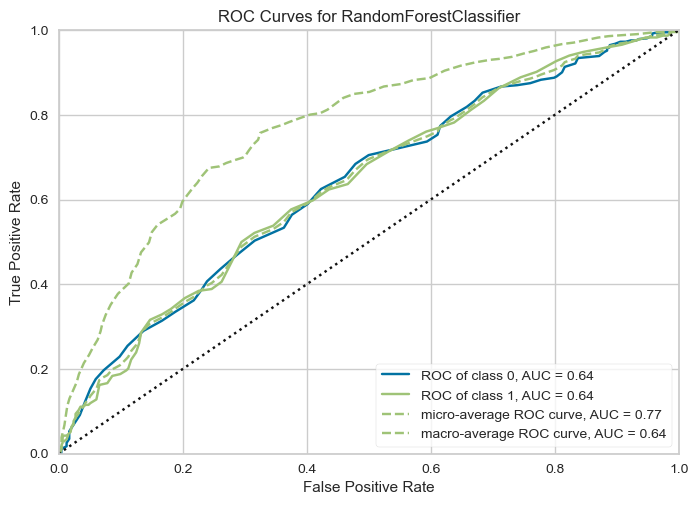

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [12]:
from pycaret.classification import plot_model, create_model
rf_model = create_model('rf')
plot_model(rf_model, plot='auc')
# Evaluate the model
evaluate_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6400,0.6564,0.6111,0.3929,0.4783,0.2228,0.2355
1,0.6100,0.6379,0.5741,0.3605,0.4429,0.1663,0.1770
2,0.6350,0.6626,0.4815,0.3662,0.4160,0.1576,0.1608
3,0.6300,0.6805,0.6909,0.4000,0.5067,0.2430,0.2663
4,0.6350,0.7092,0.6727,0.4022,0.5034,0.2427,0.2629
5,0.5700,0.6201,0.5455,0.3297,0.4110,0.1037,0.1119
6,0.5950,0.6414,0.4909,0.3375,0.4000,0.1099,0.1143
7,0.6800,0.7517,0.6182,0.4416,0.5152,0.2861,0.2951
8,0.6050,0.6405,0.6000,0.3667,0.4552,0.1728,0.1857


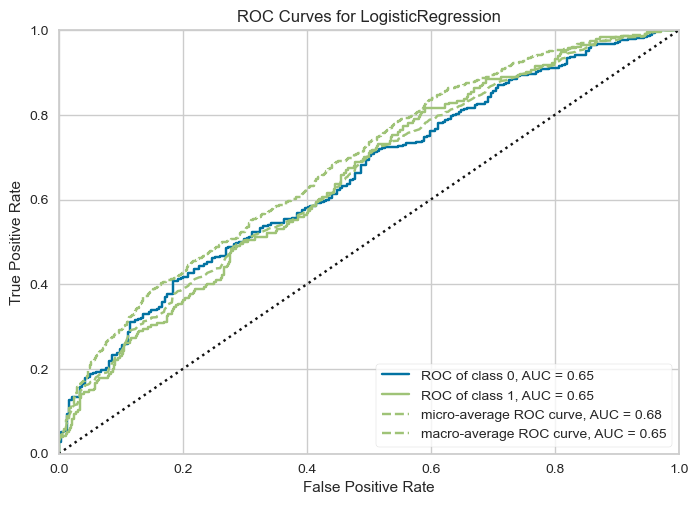

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [23]:
from pycaret.classification import plot_model, create_model
lr_model = create_model('lr')
plot_model(lr_model, plot='auc')
# Evaluate the model
evaluate_model(lr_model)

In [17]:
from pycaret.classification import create_model, get_config
import numpy as np
# Get the underlying scikit-learn model
lr_estimator = lr_model.named_steps['actual_estimator'] if 'actual_estimator' in dir(lr_model) else lr_model
# Get coefficients and feature names
coefficients = lr_estimator.coef_[0]
feature_names = get_config('X').columns
# Calculate odds ratios
odds_ratios = np.exp(coefficients)
# Display odds ratios
for feature, odds in zip(feature_names, odds_ratios):
    print(f"Feature: {feature}, Odds Ratio: {odds:.3f}")


Feature: gender, Odds Ratio: 0.805
Feature: age, Odds Ratio: 0.689
Feature: first_careunit, Odds Ratio: 1.328
Feature: icu_los_hours, Odds Ratio: 1.158
Feature: hosp_los_hours, Odds Ratio: 0.622
Feature: discharge_location, Odds Ratio: 1.299
Feature: hospital_expire_flag, Odds Ratio: 0.787
Feature: gcs_verbal, Odds Ratio: 1.010
Feature: gcs_motor, Odds Ratio: 0.801
Feature: gcs_eyes, Odds Ratio: 0.951
Feature: heart_rate, Odds Ratio: 0.806
Feature: resp_rate, Odds Ratio: 0.423
Feature: spo2, Odds Ratio: 2.776
Feature: heart_rate_avg, Odds Ratio: 0.781
Feature: resp_rate_avg, Odds Ratio: 1.456
Feature: spo2_avg, Odds Ratio: 0.975
Feature: charlson_comorbidity_index, Odds Ratio: 1.277
Feature: apsiii, Odds Ratio: 0.629
Feature: wbc_avg, Odds Ratio: 2.144
Feature: hgb_min, Odds Ratio: 1.038
Feature: creatinine_max, Odds Ratio: 0.800
Feature: glucose_avg, Odds Ratio: 0.792
Feature: inr_max, Odds Ratio: 0.918
Feature: pt_max, Odds Ratio: 0.559
Feature: has_hypertension, Odds Ratio: 0.481
Fe

In [19]:
# Paso 6: Afinar el Modelo
print("\nAfinando el modelo...")
ridge_tunned = tune_model(lr_model)



Afinando el modelo...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6400,0.6561,0.6111,0.3929,0.4783,0.2228,0.2355
1,0.6150,0.6369,0.5741,0.3647,0.4460,0.1729,0.1834
2,0.6350,0.6608,0.5000,0.3699,0.4252,0.1665,0.1705
3,0.6350,0.6815,0.6727,0.4022,0.5034,0.2427,0.2629
4,0.6400,0.7112,0.6909,0.4086,0.5135,0.2566,0.2790
5,0.5750,0.6191,0.5455,0.3333,0.4138,0.1099,0.1182
6,0.5950,0.6433,0.4909,0.3375,0.4000,0.1099,0.1143
7,0.6800,0.7542,0.6182,0.4416,0.5152,0.2861,0.2951
8,0.6250,0.6448,0.6000,0.3837,0.4681,0.1996,0.2115


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [20]:
# Paso 8: Guardar y Cargar el Modelo
print("\nGuardando el modelo...")
save_model(ridge_tunned, 'modelo_ridge_afinado')

# Cargar el modelo guardado
print("\nCargando el modelo guardado...")
loaded_model = load_model('modelo_ridge_afinado')


Guardando el modelo...
Transformation Pipeline and Model Successfully Saved

Cargando el modelo guardado...
Transformation Pipeline and Model Successfully Loaded


## 5. 📈 Visualización de Resultados

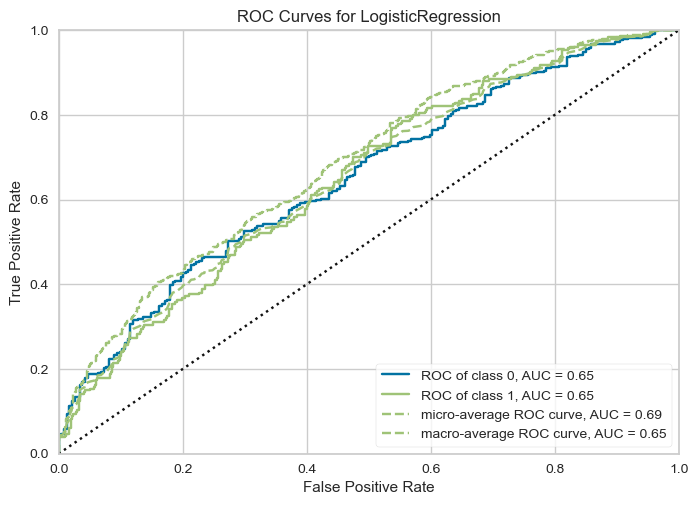

In [22]:
from pycaret.classification import plot_model

# Plot the ROC-AUC curve for the ridge model
plot_model(loaded_model, plot='auc')

## 6. 🚀 Despliegue (Futuro)
Se puede utilizar Hugging Face Spaces o Streamlit Cloud para desplegar un frontend que permita:
- Cargar variables clínicas
- Obtener un score de riesgo
- Visualizar el gráfico ROC o una matriz de confusión